# Make a glm matrix
The purpose of this script is to generate a glm matrix based on the phenotypic file

In [14]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
# Paths
use = 'target'
f_pheno = '/data1/abide/Pheno/glm_pheno.csv'
f_glm = '/data1/scores/glm/abide/glm_abide.mat'
f_sub = '/data1/scores/glm/abide/subjects.csv'
f_seed_path = '/data1/scores/glm/abide/seed_paths_{}.csv'.format(use)
f_scores_path = '/data1/scores/glm/abide/scores_paths_{}.csv'.format(use)
f_dual_path = '/data1/scores/glm/abide/dual_paths_{}.csv'.format(use)
scores_path = '/data1/abide/Out/Scores/sc07/{}/stability_maps'.format(use)
seed_path = '/data1/abide/Out/Scores/sc07/time/rmap_part'
dual_path = '/data1/abide/Out/Scores/sc07/time/dual_regression'
scores_temp = '*_fmri_{:07d}_session_1_run1_stability_maps.nii.gz'
seed_temp = '*_fmri_{:07d}_session_1_run1_rmap_part.nii.gz'
dual_temp = '*_fmri_{:07d}_session_1_run1_dual_regression.nii.gz'

In [17]:
pheno = pd.read_csv(f_pheno)

In [18]:
pheno.keys()

Index([u'sub', u'site', u'sex', u'diag', u'age', u'mean_fd'], dtype='object')

In [19]:
sites = list(pheno['site'].unique())
# We now know that I don't have Yale so I'll drop it
sites.pop(sites.index('YALE'))
#drop_list = sites(0)
#sites.pop(drop_list)
num_sites = len(sites)
# Add the number of sites to this but subtract 2 (because site is a covariate as well
# and one site will be excluded
num_covs = len(pheno.keys()) + num_sites -2

In [20]:
sub_list = list()
scores_list = list()
seed_list = list()
dual_list = list()

for index, row in pheno.iterrows():
    # Find out if this guy has a file where we are looking for it
    search_seed = os.path.join(seed_path, seed_temp.format(row['sub']))
    match_seed = glob.glob(search_seed)
    search_scores = os.path.join(scores_path, scores_temp.format(row['sub']))
    match_scores = glob.glob(search_scores)
    search_dual = os.path.join(dual_path, dual_temp.format(row['sub']))
    match_dual = glob.glob(search_dual)
    site = row['site']
    if not match_seed or not match_scores or not match_dual or not site in sites:
        print('not using {}'.format(site))
        continue
        
    # Append the paths
    sub_list.append('{}\n'.format(row['sub']))
    scores_list.append('{}\n'.format(match_scores[0]))
    seed_list.append('{}\n'.format(match_seed[0]))
    dual_list.append('{}\n'.format(match_dual[0]))

num_subs = len(sub_list)
glm_mat = np.zeros((num_subs, num_covs))

count = 0
for index, row in pheno.iterrows():
    index = count
    # Find out if this guy has a file where we are looking for it
    search_seed = os.path.join(seed_path, seed_temp.format(row['sub']))
    match_seed = glob.glob(search_seed)
    search_scores = os.path.join(scores_path, scores_temp.format(row['sub']))
    match_scores = glob.glob(search_scores)
    search_dual = os.path.join(dual_path, dual_temp.format(row['sub']))
    match_dual = glob.glob(search_dual)
    site = row['site']
    if not match_seed or not match_scores or not match_dual or not site in sites:
        continue
    # Add covariates
    # Sex
    glm_mat[index, 1] = row['sex'] - 1
    # Diagnosis
    glm_mat[index, 2] = row['diag'] - 1
    # Age
    glm_mat[index, 3] = row['age']
    # Mean FD
    glm_mat[index, 4] = row['mean_fd']
    # Site
    site = row['site']
    site_id = sites.index(site)
    if site_id == 0:
        # first site doesn't get assigned a covariate
        continue
    # Otherwise add 1 at the correct location
    glm_mat[index, 4+site_id] = 1
    count += 1
# Demean the covariates
mean_vec = np.mean(glm_mat, 0)
glm_mat -= mean_vec
# Add the intercept as the first covariate
glm_mat[:,0] = 1

not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using YALE
not using 

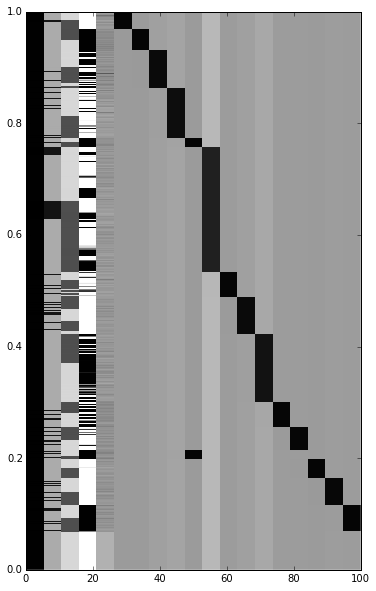

In [21]:
f = plt.figure(figsize=[6,10])
ax = f.add_subplot(111)
ax.imshow(glm_mat, extent=[0,100,0,1], aspect='auto', cmap=cm.Greys, vmin=-1, vmax=1, interpolation='None')

In [22]:
# Save the mat file
sio.savemat(f_glm, mdict={'glm': glm_mat})

In [23]:
with open(f_sub, 'w') as outfile:
    outfile.writelines(sub_list)

In [24]:
with open(f_seed_path, 'w') as outfile:
    outfile.writelines(seed_list)
with open(f_scores_path, 'w') as outfile:
    outfile.writelines(scores_list)
with open(f_dual_path, 'w') as outfile:
    outfile.writelines(dual_list)

## Now to create the contrast vectors

In [25]:
names = ['intercept', 'sex', 'diag', 'age', 'mean_fd'] + sites

In [26]:
names

['intercept',
 'sex',
 'diag',
 'age',
 'mean_fd',
 'MAX_MUN',
 'UCLA_2',
 'SBL',
 'PITT',
 'UCLA_1',
 'CMU',
 'NYU',
 'SDSU',
 'KKI',
 'USM',
 'OLIN',
 'LEUVEN_2',
 'OHSU',
 'STANFORD',
 'CALTECH']